
# Zcash Observatory data

Mitchell Krawiec-Thayer and Pranav Thirunavukkarasu

June 2020

Observatory R & D at Insight supported by the Zcash Foundation


## Settings for this notebook

In [1]:
path_to_files = '.'
savedata = 1 # boolean setting
qverbose = 1 # boolean setting

remove_sync_hack = 0 # deprecated

min_obs_witness = 1 # Mask height unless witnessed by this number of observatories
sync_threshold = 0 # seconds interval for block inv messages
envelope_cutoff = -9999 # max prop time, anything longer sync # not implemented yet
block_time = 75 # seconds

## Import libraries

In [2]:
import numpy as np;
import matplotlib.pyplot as plt;
import pandas as pd;
import math;
import os;

## Define functions

In [3]:
# This creates heatmap visualizations

def Heatmap(x, y, LinBins = (60,60), LogBins = (60,60), title = '', xlabel = '', ylabel = '', yscale = 'linear', xscale = 'linear', onlyplot = '', vmax = 'auto', vmin = 0, clabel='', ymax = 'auto'):
    # import numpy as np
    # import matplotlib.pyplot as plt
    # MPKT 2019.06

    # Note that this is a hacky function that cannot handle NaNs at the moment
    
    if ymax == 'auto':
        ymax_val = np.log10(int(np.max(x)))
    else:
        ymax_val = np.log10(int(ymax))
    
    # Log plot
    if not onlyplot == 'linear':
        fig = plt.figure(figsize=(15,5), facecolor='white')
        if len(LogBins) == 2:
            yedges = np.logspace(np.log10(1),ymax_val, LogBins[1])
        H, xedges, yedges = np.histogram2d(list(x),list(y), bins=(LogBins[1],yedges))
        
        # H needs to be rotated and flipped
        H = np.rot90(H)
        H = np.flipud(H)
        
        if vmax == 'auto':
            vmax = np.max(H)
        # Plot 2D histogram using pcolor
        plt.pcolormesh(xedges,yedges,H,vmax=vmax, vmin=vmin)
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(clabel)                                          
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xscale(xscale)
        plt.yscale(yscale)
        plt.show()
        
        return fig;

## Import data
Assumes that data is in directories named by node ID (location)

The cell that reads in CSV files also heavily processes, and may take minutes to run

### Analyze directory structure

In [4]:
# What are the nearby directories
folders = [x[0] for x in os.walk(path_to_files)]

# Initialize
node_names = list()
for f in range(len(folders)):
    this_folder_raw = folders[f]
    if not (this_folder_raw[0:3] == './.' or this_folder_raw == '.'):
        node_names.append(this_folder_raw[2::])
print('node_names:')
print (node_names)

node_names:
['mumbai', 'virginia', 'london', 'africa']


### Read in data from all nodes

In [5]:
# Import data, iterating over nodes

timestamps_df = pd.DataFrame()
heights_df = pd.DataFrame()

for f in range(len(node_names)):
    this_node_name = node_names[f]

    # Import height data
    blocks_file_name = os.path.join(this_node_name,'blocks_v1.csv')
    temp_df1 = pd.read_csv(blocks_file_name, index_col = 'Hash')
    temp_df1 = temp_df1.filter(["Hash", "Height"], axis=1)
    temp_df1['Obs_Node_Name'] = this_node_name
    heights_df = heights_df.append(temp_df1)

    # Import timestamp data
    heights_file_name = os.path.join(this_node_name,'inv_v1.csv')
    temp_df2 = pd.read_csv(heights_file_name, index_col = 'Hash')
    timestamps_df = timestamps_df.append(temp_df2)


In [6]:
# Join heights
all_data = timestamps_df.join(heights_df.drop_duplicates(), on='Hash') # temp hook

## Data QC

### Peer piecewise analysis

What are all peers that we saw?`

In [7]:
global_peerlist = list(set(all_data['Peer_IP']))
slow_peer = '192.64.112.23'
slow_peer_index = global_peerlist.index('192.64.112.23')

### Remove sync data (loop over peers)

In [8]:
heights_to_keep = list()
heights_to_mask = list()
non_sync_data = pd.DataFrame()

for p in range(len(global_peerlist)):
    if qverbose: 
        if p % 10 == 0:
            print("Peer " + str(p+1) + ' of ' + str(len(global_peerlist)))
    this_IP = global_peerlist[p]
    this_peer_data = all_data[all_data['Peer_IP'] == this_IP]
    this_peer_data = this_peer_data.reset_index()
    heights_seen_raw = list(set(this_peer_data['Height']))
    heights_seen = [x for x in heights_seen_raw if not np.isnan(x)]
    
    # De-dupe heights
    first_heard_df = this_peer_data.groupby(['Height'])['Validated_Time'].min().to_frame().reset_index()
    
    # Split into parallel lists
    height_array = list(first_heard_df["Height"])
    time_array = list(first_heard_df["Validated_Time"])

    for h in range(len(height_array)):
        # get data for this block
        this_height = height_array[h]
        this_time = time_array[h]
        
        # did the previous block exist
        last_height = this_height - 1
        try:
            last_height_index = height_array.index(last_height)
            last_time = time_array[last_height_index]
            
            if this_time - last_time > sync_threshold:
                heights_to_keep.append(this_height)
            else:
                # previous block was too recent
                heights_to_mask.append(this_height)
        except:
            # didn't see previous block
            heights_to_mask.append(this_height)
            

    # Okay, now remove those rows from the all-node this-peer data 
    for h in range(len(heights_to_mask)):
        this_height = heights_to_mask[h]
        idx = this_peer_data.index[this_peer_data['Height'] == this_height].tolist()
        
        if len(idx) > 0:
            if len(idx) > 1:
                for i in range(len(idx)):
                    this_peer_data.iat[i,1] = np.nan 
            else: # len(idx) == 1:
                this_peer_data.iat[idx[0],1] = np.nan 

    this_peer_data = this_peer_data.dropna()
    
    non_sync_data = non_sync_data.append(this_peer_data)

Peer 1 of 230
Peer 11 of 230
Peer 21 of 230
Peer 31 of 230
Peer 41 of 230
Peer 51 of 230
Peer 61 of 230
Peer 71 of 230
Peer 81 of 230
Peer 91 of 230
Peer 101 of 230
Peer 111 of 230
Peer 121 of 230
Peer 131 of 230
Peer 141 of 230
Peer 151 of 230
Peer 161 of 230
Peer 171 of 230
Peer 181 of 230
Peer 191 of 230
Peer 201 of 230
Peer 211 of 230
Peer 221 of 230


In [9]:
summary_df = pd.DataFrame(columns=['Height','Hash','First_Time','Prop_Time','Obs_Witness_Count','Peers_Report_Count','Sorted_Timestamps'])

## Feature Engineering

In [10]:
witness_df = pd.DataFrame()
global_height_list_raw = list(set(all_data['Height']))
global_height_list = [x for x in global_height_list_raw if not np.isnan(x)]
summary_df = pd.DataFrame(columns=['Height','Hash','First_Time','Prop_Time','Obs_Witness_Count','Peers_Report_Count','Sorted_Timestamps'])

height_col = list()
hash_col = list()
first_col = list()
prop_time_col = list()
obs_wit_col = list()
peers_col = list()
timestamps_col = list()

for h in range(len(global_height_list)):
    if qverbose > 0: 
        if h % 250 == 0:
            print(str(h) + ' of ' + str(len(global_height_list)))
    this_height = global_height_list[h]
    this_height_df = non_sync_data[non_sync_data["Height"] == this_height]
    height_col.append(this_height)
    # hash_col.append()
        
    try: 
        raw_times = this_height_df['Validated_Time']
        if qverbose > 2: print('***')
        if qverbose > 2: print('Height: ' + str(this_height))
        if qverbose > 2: print('Raw times: ' + str(raw_times))
        min_time = min(raw_times) # get the min time 
        if qverbose > 2: print('Min time: '+ str(min_time))
        max_allowed = min_time + block_time 
        if qverbose > 2: print('Max allowed: ' + str(max_allowed))
        allowed_times = raw_times[raw_times<max_allowed]   
        if qverbose > 2: print('Allowed times: ' + str(allowed_times))  
        max_time = max(allowed_times)
        if qverbose > 2: print('Max time: ' + str(max_time))
        prop_time = max_time - min_time
        if qverbose > 2: print('Prop time: ' + str(prop_time))
    except:
        min_time = np.nan
        prop_time = np.nan
        
    first_col.append(min_time)
    prop_time_col.append(prop_time)   
    
    # Count witnesses
    obs_witnesses = list(set(this_height_df["Obs_Node_Name"]))
    num_obs_witness = len(obs_witnesses) 
    obs_wit_col.append(num_obs_witness)
    
    # Count IPs
    peers_reported = list(set(this_height_df["Peer_IP"]))
    num_peers_reported = len(peers_reported) 
    peers_col.append(num_peers_reported)   
    
summary_df['Height'] = height_col
# summary_df['Hash'] = hash_col
summary_df['First_Time'] = first_col
summary_df['Prop_Time'] = prop_time_col
summary_df['Obs_Witness_Count'] = obs_wit_col
summary_df['Peers_Report_Count'] = peers_col
# summary_df['Sorted_Timestamps'] = timestamps_col



    # if num_obs_witness >= min_obs_witness:
    #     if qverbose > 2: print('kept with ' + str(num_obs_witness) + ' witnesses')
    #     witness_df = witness_df.append(this_height_df)
    # else:
    #     if qverbose > 2: print('rejected with only ' + str(num_obs_witness) + ' witnesses')

0 of 8184
250 of 8184
500 of 8184
750 of 8184
1000 of 8184
1250 of 8184
1500 of 8184
1750 of 8184
2000 of 8184
2250 of 8184
2500 of 8184
2750 of 8184
3000 of 8184
3250 of 8184
3500 of 8184
3750 of 8184
4000 of 8184
4250 of 8184
4500 of 8184
4750 of 8184
5000 of 8184
5250 of 8184
5500 of 8184
5750 of 8184
6000 of 8184
6250 of 8184
6500 of 8184
6750 of 8184
7000 of 8184
7250 of 8184
7500 of 8184
7750 of 8184
8000 of 8184


In [11]:
summary_df.head()

,Height,Hash,First_Time,Prop_Time,Obs_Witness_Count,Peers_Report_Count,Sorted_Timestamps
0,851975.0,NaN,1.591051e+09,11.817,4,140,NaN
1,851976.0,NaN,1.591051e+09,4.939,4,140,NaN
2,851977.0,NaN,1.591051e+09,10.560,4,140,NaN
3,851978.0,NaN,1.591051e+09,17.723,4,140,NaN
4,851979.0,NaN,1.591051e+09,11.594,4,140,NaN


## Review data 

## Visualize data

### Probability density function plot

First, let's look at histograms of the global propagation time.

The first plot uses linear axes, and the second plot shows the same thing with log axes.

This is called the "probability density function" (PDF)

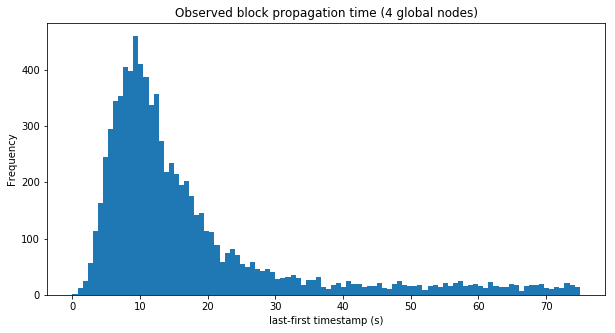

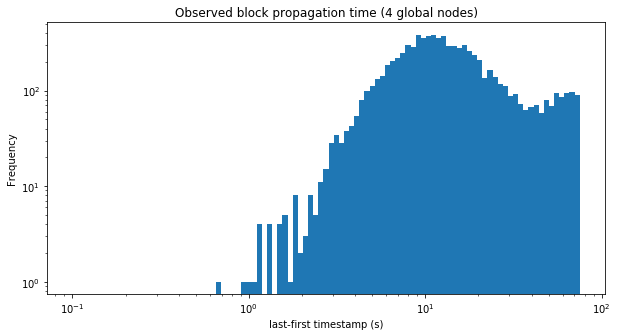

In [12]:
# Linear plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(summary_df['Prop_Time'], bins=100)
plt.xlabel('last-first timestamp (s)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)')

# Log plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
hdata = summary_df['Prop_Time']
plt.hist(summary_df['Prop_Time'], bins=np.logspace(np.log10(min(hdata)+0.1),np.log10(max(hdata)),100));
plt.yscale('log')
plt.xscale('log')
plt.xlabel('last-first timestamp (s)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)');

### Cumulative distribution function plot

Now let's look at a closely-related plot, the "cumulative distribution function" (CDF)

Crosshairs have been added to show how to interpret this plot. (Note that when the data are updated, the static crosshairs may not match up with the plot / data anymore)

For a given crosshair, <y-axis coordinate> fraction of blocks propagate in under <x-axis coordinate> seconds
    
Black line shows that 50% of blocks propagate in under 250 ms. Red line shows that 85% of blocks propagate in under 850 ms (meaning that 15% of Zcash blocks take more than 800 ms to propagate)

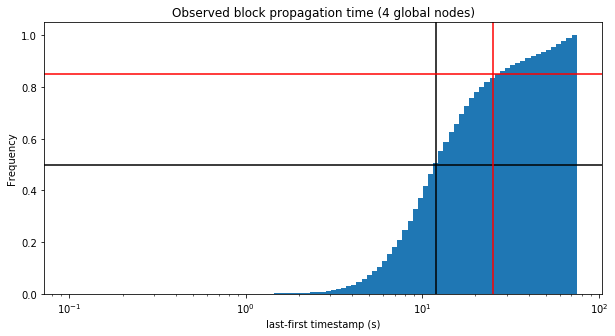

In [22]:
# Generate plot

height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(summary_df['Prop_Time'], bins=np.logspace(np.log10(min(hdata)+0.1),np.log10(max(hdata)),100), cumulative=True, density=True);
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('last-first timestamp (s)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)')


# Add labels to explain
plt.axvline(x=12, color='black')
plt.axhline(y=0.5, color='black')
plt.axvline(x=25, color='red')
plt.axhline(y=0.85, color='red');

### Scatter plot

Now let's plot each block as a dot where x-axis is the block height, and y-axis is the observed global propagation time

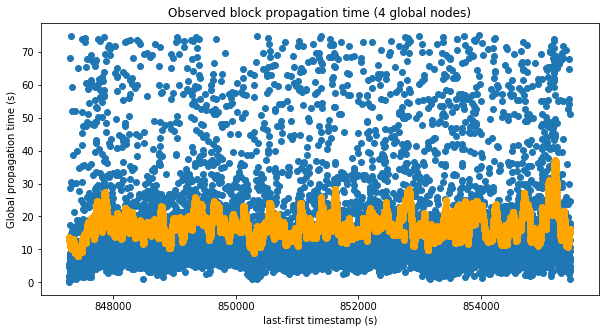

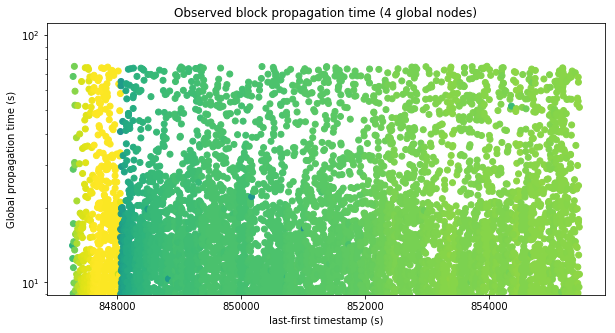

In [31]:
rolling_mean = summary_df.Prop_Time.rolling(window=48*10).mean()

fig = plt.figure(figsize=(10,5), facecolor='w')
plt.scatter(x=summary_df['Height'], y=summary_df['Prop_Time'])
plt.xlabel('last-first timestamp (s)')
plt.ylabel('Global propagation time (s)')
plt.title('Observed block propagation time ('+str(len(node_names))+' global nodes)');
rolling_mean = summary_df.Prop_Time.rolling(window=48).mean()
plt.scatter(summary_df.Height, rolling_mean, label='hour rolling window', color='orange')

fig = plt.figure(figsize=(10,5), facecolor='w')
plt.scatter(x=summary_df['Height'], y=summary_df['Prop_Time'], c=summary_df['Peers_Report_Count'])
plt.xlabel('last-first timestamp (s)')
plt.ylabel('Global propagation time (s)')
plt.title('Observed block propagation time ('+str(len(node_names))+' global nodes)');
plt.yscale('log')

### Heatmap plots
(same concept as the scatter plots above, except shaded)

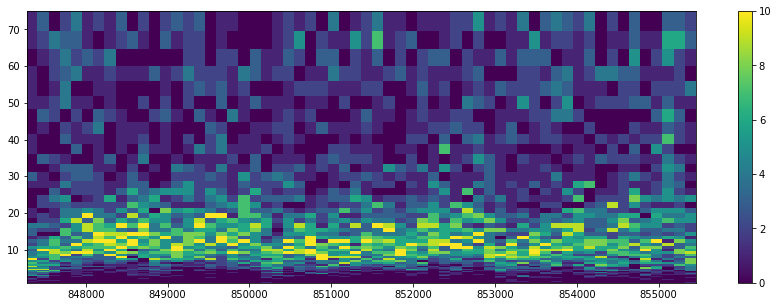

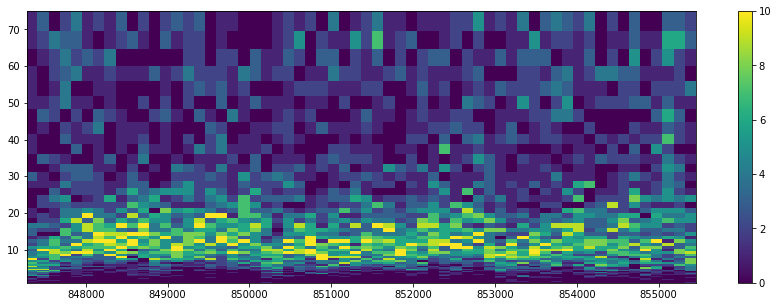

In [24]:
Heatmap(x=summary_df['Height'], y=summary_df['Prop_Time'], ymax=75, vmax=10)

## Save data
Data frame to CSV if desired

In [16]:
if savedata:
    summary_df.to_csv('summary_df.csv', index_label = 'block_hash')